# Example 10: Variational Auto-encoder (VAE)


<a href="https://colab.research.google.com/github/PGM-Lab/ProbModelingDNNs/blob/master/notebooks/Example10-VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Variational Auto-encoders (VAE) (Kingma & Welling, 2013; Doersch, 2016) are probably the most influential models 
combining LVMs and DNNs. VAEs extend the classical technique of principal component analysis (PCA) (Jolliffe, 2011) 
for data representation in lower-dimensional spaces.

The pseudo-code blow provides a description of the generative model of a VAE. 

<img src="https://raw.githubusercontent.com/PGM-Lab/ProbModelingDNNs/master/img/nlpca_pseudocode.png" alt="VAE-pseudocode" style="width: 700px;"/>

The present notebook experimentally illustrates the behavior of a VAE as a feature reduction method on (a reduced version of) 
MNIST dataset. The model is implemented using the Edward2 from tensorflow-probability.


Note that the generative model is identical to the one in a variational auto-encoder, whcih is presented in a separated 
notebook. The difference is that the formulation of VAEs includes an amortized inference function linking the data samples 
with the latent variables $\boldsymbol{z}$. In practice, this will affect to the model defining the Q model.


## Setting up the system

First, we will install and import the required packages as follows.



In [1]:
!pip install tensorflow
!pip install tensorflow-probability
!pip install keras
!pip install matplotlib
!pip install inferpy
!pip install setuptools

In [2]:
import tensorflow as tf
from tensorflow_probability import edward2 as ed
import numpy as np
import matplotlib.pyplot as plt
import inferpy as inf
from inferpy.datasets import mnist
import numpy as np

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Global configuration
num_epochs = 1000
tf.reset_default_graph()
tf.set_random_seed(1234)
verbose = True
learning_rate = 0.01


Using TensorFlow backend.


## Data 

For illustrating purposes, the MNIST dataset containg handwritten digits will be used. In particular we might obtain the data from the ``inferpy`` package (and hence from keras):

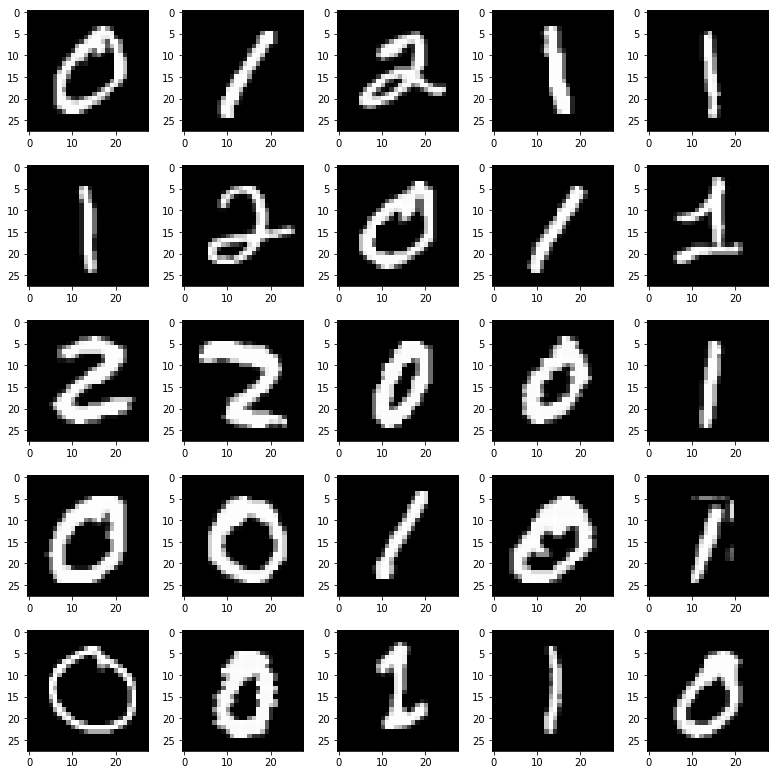

In [3]:
# number of observations (dataset size)
N = 1000
# digits considered
DIG = [0,1,2]

# load the data
(x_train, y_train), _ = mnist.load_data(num_instances=N, digits=DIG)

# plot the digits
mnist.plot_digits(x_train, grid=[5,5])

We might split the data into batches of size ``M``.

In [4]:
M = 100
batches = np.array_split(x_train, N / M)
batch = tf.placeholder(dtype=tf.float32, name="batch", shape=[M, np.shape(x_train)[-1]])

### Model definition

The implementation for the generative model for a VAE model (Algorithm 3) is defined below. The input parameters are: `k` is the latent dimension, `d` is the data-dimension and `N`the number of samples or data instances. 

In [5]:
# Model constants
k, d0, d1 = 2, 100, 28 * 28

# initial values
scale_init_encoder = 0.01
scale_epsilon = 0.01


def vae(k, d0, d1, N, decoder):
    # Define local latent variables
    z = ed.Normal(loc=tf.zeros(k), scale=tf.ones(k), sample_shape=N, name="z")

    output, weights = decoder(z, k, d0, d1)

    # Define the observed variables
    x = ed.Normal(loc=output, scale=1., name="x")

    return z, weights, x


def decoder(z, k, d0, d1):  # z -> x (k -> d0 -> 2*d1)

    beta0 = ed.Normal(tf.zeros([k, d0]),
                      1., name="beta0")
    alpha0 = ed.Normal(tf.zeros([d0]),
                       1., name="alpha0")

    h0 = tf.nn.relu(z @ beta0 + alpha0, name="h0")

    ######

    beta1 = ed.Normal(tf.zeros([d0, d1]),
                      1., name="beta1")
    alpha1 = ed.Normal(tf.zeros([d1]),
                       1., name="alpha1")

    output = h0 @ beta1 + alpha1

    #####

    return output, (beta0, alpha0, beta1, alpha1)



print(vae)
print(decoder)

<function vae at 0x1305e9c80>
<function decoder at 0x1305e9bf8>


This is a latent varable model (LVM) containing DNNs where the latent representation $\boldsymbol{z}$ is known as the scores, and the affine transformation is performed using a DNN parametrized by $\boldsymbol{\beta}$ and $\boldsymbol{\alpha}$.

### Inference

Variational inference is a deterministic technique that finds a tractable approximation to an intractable (posterior) distribution. 
We will use $q$ to denote the approximation, and use $p$ to signify the true distribution (like $p(\boldsymbol{\beta, \alpha},\boldsymbol{z}|\boldsymbol{x})$ in the example above).
More specifically, ${\cal Q}$ will denote a set of possible approximations $q$.



Usually, we might define a generative model for sampling from $q(\boldsymbol{\beta, \alpha},\boldsymbol{z} | \boldsymbol{\lambda}, \boldsymbol{\phi})$. However, $\boldsymbol{\phi}$ is a parameter vector that grows with the data, $\boldsymbol{\phi} = (\boldsymbol{\phi}_1,\ldots,\boldsymbol{\phi}_N)$, giving rise to an optimization problem which can not be handled when the model involves big data sets. 

Amortized inference solves this problem by learning a mapping function, denoted by $\boldsymbol{s}$, between $\boldsymbol{x}_i$ and $\boldsymbol{\phi}_i$ parameterized by $\boldsymbol{theta}$. Moreover this mapping will be a neural network, known in the literature as the decoder network.


Therefore we will defined a generative model for sampling from $q(\boldsymbol{\beta, \alpha},\boldsymbol{z} | \boldsymbol{x, \lambda, \theta)}$ as follows.




In [6]:


def encoder(x, k, d0, d1):
    beta0 = tf.Variable(tf.random_normal([d1, d0], stddev=scale_init_encoder), name="encoder_beta0")
    alpha0 = tf.Variable(tf.zeros([d0]), name="encoder_alpha0")
    h0 = tf.nn.relu(x @ beta0 + alpha0, name="encoder_h0")

    ######

    beta1 = tf.Variable(tf.random_normal([d0, 2 * k], stddev=scale_init_encoder), name="encoder_beta1")
    alpha1 = tf.Variable(tf.zeros([2 * k]), name="encoder_alpha1")
    output = h0 @ beta1 + alpha1

    return output


def Q(k, d0, d1, x, encoder):
    output = encoder(x, k, d0, d1)

    qz_loc = output[:, :k]
    qz_scale = output[:, k:]

    qz = ed.Normal(loc=qz_loc,
                   scale=tf.nn.softplus(qz_scale + tf.math.log(tf.math.expm1(scale_init_encoder))) + scale_epsilon,
                   name="qz")

    ###

    qbeta0_loc = tf.Variable(tf.zeros([k, d0]), name="qbeta0_loc")
    qbeta0_scale = tf.math.softplus(
        tf.Variable(tf.zeros([k, d0]), name="qbeta0_scale") + tf.math.log(tf.math.expm1(scale_init_encoder)))
    qbeta0 = ed.Normal(qbeta0_loc, qbeta0_scale + scale_epsilon, name="qbeta0")

    qalpha0_loc = tf.Variable(tf.zeros([d0]), name="qalpha0_loc")
    qalpha0_scale = tf.math.softplus(
        tf.Variable(tf.zeros([d0]), name="qalpha0_scale") + tf.math.log(tf.math.expm1(scale_init_encoder)))
    qalpha0 = ed.Normal(qalpha0_loc, qalpha0_scale + scale_epsilon, name="qalpha0")

    ###

    qbeta1_loc = tf.Variable(tf.zeros([d0, d1]), name="qbeta1_loc")
    qbeta1_scale = tf.math.softplus(
        tf.Variable(tf.zeros([d0, d1]), name="qbeta1_scale") + tf.math.log(tf.math.expm1(scale_init_encoder)))
    qbeta1 = ed.Normal(qbeta1_loc, qbeta1_scale + scale_epsilon, name="qbeta1")

    qalpha1_loc = tf.Variable(tf.zeros([d1]), name="qalpha1_loc")
    qalpha1_scale = tf.math.softplus(
        tf.Variable(tf.zeros([d1]), name="qalpha1_scale") + tf.math.log(tf.math.expm1(scale_init_encoder)))
    qalpha1 = ed.Normal(qalpha1_loc, qalpha1_scale + scale_epsilon, name="qalpha1")

    ###

    return qz, (qbeta0, qalpha0, qbeta1, qalpha1)


print(Q)


<function Q at 0x1305e97b8>


Variational methods adjusts the parameters by maximizing the ELBO (Evidence LOwer Bound) denoted $\cal{L}$ and expressed as 

$\cal{L}(\boldsymbol{\lambda},\boldsymbol{\theta})  = \mathbb{E}_q [\ln p(\boldsymbol{\beta})] - \mathbb{E}_q [\ln q(\boldsymbol{\beta}|\boldsymbol{\lambda})] + N \cdot \mathbb{E}_q [\ln p(\boldsymbol{x}_I, \boldsymbol{z}_I | \boldsymbol{\beta})] - N \cdot\mathbb{E}_q [\ln q(\boldsymbol{z}_I| \boldsymbol{x}_I, \boldsymbol{\phi}_I = \boldsymbol{s}(\boldsymbol{x}_i | \boldsymbol{\theta}))]$

In Edward, this is done as follows.

In [7]:
def set_values(**model_kwargs):
    """Creates a value-setting interceptor."""
    def interceptor(f, *args, **kwargs):
        """Sets random variable values to its aligned value."""
        name = kwargs.get("name")
        if name in model_kwargs:
            kwargs["value"] = model_kwargs[name]
        else:
            print(f"set_values not interested in {name}.")
        return ed.interceptable(f)(*args, **kwargs)
    return interceptor


qz, qw = Q(k, d0, d1, batch, encoder)
qw_dict = {v.distribution.name.split("_")[0].split("/")[0][1:]: v for v in qw}


with ed.interception(set_values(z=qz, x=batch, **qw_dict)):
    pz, pw, px = vae(k, d0, d1, M, decoder)

energy = N/M*tf.reduce_sum(pz.distribution.log_prob(pz.value)) + \
         N/M*tf.reduce_sum(px.distribution.log_prob(px.value)) + \
         tf.reduce_sum([tf.reduce_sum(v.distribution.log_prob(v.value)) for v in pw])

entropy = N/M*tf.reduce_sum(qz.distribution.log_prob(qz.value)) + \
          tf.reduce_sum([tf.reduce_sum(v.distribution.log_prob(v.value)) for v in qw])

elbo = energy - entropy

print(elbo)


Tensor("sub:0", shape=(), dtype=float32)


Finally, the ELBO function is maximized.

In [8]:
# auxiliary functions

def predictive_encoder(x, beta0, alpha0, beta1, alpha1):
    h0 = tf.nn.relu(x @ beta0 + alpha0, name="encoder_h0")
    output = h0 @ beta1 + alpha1
    return output

def get_tfvar(name):
    for v in tf.trainable_variables():
        if str.startswith(v.name, name):
            return v

# optimization loop
        
with tf.Session() as sess: 
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train = optimizer.minimize(-elbo)
    init = tf.global_variables_initializer()
    sess.run(init)
    t = []
    for i in range(num_epochs+1):
        for j in range(N//M):
            elbo_ij = sess.run(elbo, feed_dict = {batch: batches[j]})
            if j==(N//M-1):
                t.append(elbo_ij)

            sess.run(train, feed_dict = {batch: batches[j]})
            
            if verbose:

                if i % 10 == 0 and j==N//M-1: print(".", end="", flush=True)
                if i % 200 == 0 and j==N//M-1:
                    str_elbo = str(t[-1] / 1000) + " k"
                    print("\n" + str(i) + " epochs\t" + str_elbo, end="", flush=True)

    weights_encoder = [sess.run(get_tfvar("encoder_"+name)) for name in ["beta0", "alpha0", "beta1", "alpha1"]]
    postw = {k: sess.run(v) for k, v in qw_dict.items()}
    post = {"z": sess.run(predictive_encoder(x_train, *weights_encoder)[:,:k]), **postw}
        

.
0 epochs	-1739299.328 k....................
200 epochs	-904226.048 k....................
400 epochs	-839260.48 k....................
600 epochs	-795886.976 k....................
800 epochs	-772084.352 k....................
1000 epochs	-801665.408 k

After the inference, we can plot the hidden representation:

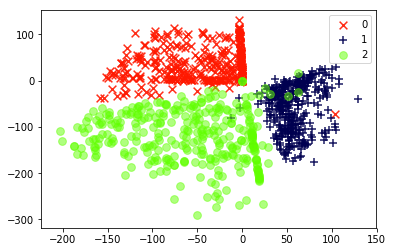

In [9]:
markers = ["x", "+", "o"]
colors = [plt.get_cmap("gist_rainbow")(0.05),
          plt.get_cmap("gnuplot2")(0.08),
          plt.get_cmap("gist_rainbow")(0.33)]
transp = [0.9, 0.9, 0.5]

fig = plt.figure()

for c in range(0, len(DIG)):
    col = colors[c]
    plt.scatter(post["z"][y_train == DIG[c], 0], post["z"][y_train == DIG[c], 1], color=col,
                label=DIG[c], marker=markers[c], alpha=transp[c], s=60)
    plt.legend()

plt.show()



## Test

For testing our model, we will generate samples of $\boldsymbol{x}$ given the infered posterior distributions.

set_values not interested in x.


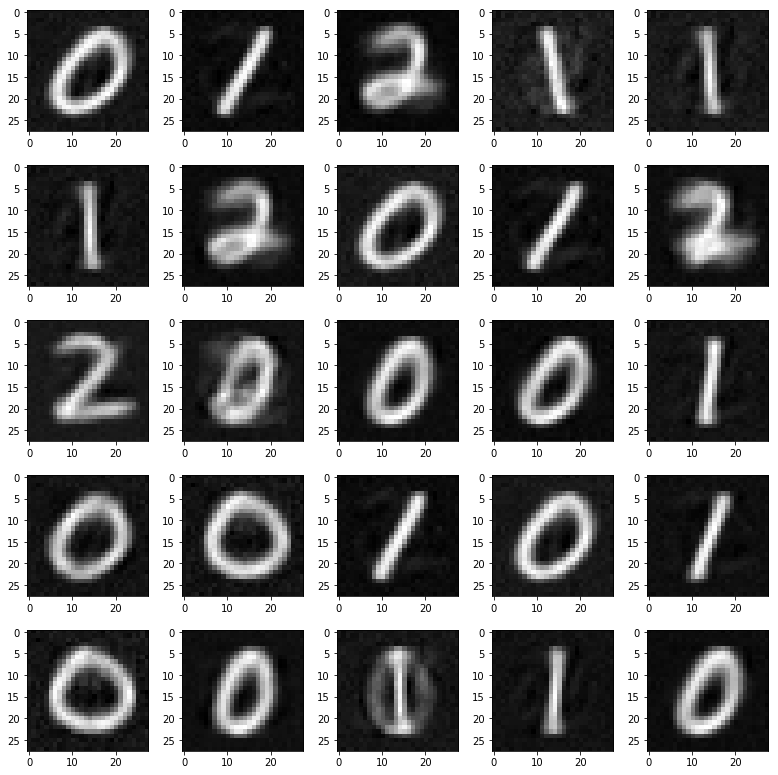

In [10]:
with ed.interception(set_values(**post)):
    generate = vae(k, d0, d1, N, decoder)

with tf.Session() as sess:
    _, _, x_gen = sess.run(generate)
    
# plot the digits
mnist.plot_digits(x_gen, grid=[5,5])